In [1]:
# %%

import numpy as np
from scipy.io.wavfile import read
import matplotlib.pyplot as plt
import warnings
import time
import math


def diff(x: np.array,
         tau_max: int,
         start: int,
         w: int) -> np.array:
    """
    B. Step 2: Difference Function. Calculate the difference function of one frame
    in Eq (6). 
    This is a sequential implementation, to be optimised

    Args:
        x (np.array): The input signal
        tau_max (int): An upper limit for the lag parameter tau (exclusive)
        start (int): The starting index in the signal
        w (int): integration window size

    Returns:
        np.array: A list of results calculated with different values of tau
    """

    # w < len(x)
    # tau_max - 1 + start + max_j (w) < len(x) => tau_max < len(x) + 1 - start - w
    assert tau_max < len(x) + 1 - start - w and tau_max < w
    # allocate the difference function outputs
    difference: np.array = np.zeros((tau_max, ))
    x = np.array(x, dtype=np.int32)
    for t in range(tau_max):
        df = 0
        start_j = x[start + 1: start + w + 1]
        start_j_t = x[start + 1 + t: start + w + 1 + t]
        # for j in range(1, w + 1):
        #     df += (x[start + j] - x[start + j + t]) ** 2
        df = ((start_j - start_j_t) ** 2).sum()
        difference[t] = df

    return np.array(difference, dtype=np.float64)


def cmndiff(difference: np.array) -> np.array:
    """C. Step 3: Cumulative Mean Normalized Difference Function. Calculate the cmndiff of 
    one frame in Eq (8)

    Args:
        difference (np.array): the difference function calculated from diff

    Returns:
        np.array: a list of results
    """

    # add a 0 at the beginning to make the index align
    diff_cumulative = difference.cumsum()
    diff_zero_tau = 1
    diff_positive_tau = difference[1:] / (
        (1 / np.array([i for i in range(1, len(difference))])) * difference.cumsum()[1:])

    return np.concatenate((np.array([diff_zero_tau]), diff_positive_tau))


def abs_threshold(cmndiff: np.array, threshold: float = 0.1) -> int:
    """D. Step 4: Absolute Threshold. Choose an absolute threshold and take the minimum value of tau
    that gives the minimum of d' deeper than that threshold. If none is found, choose the global minimum instead.
    A minimum of d' deeper than the threshold is equivalent to choosing one threshold and find the minimum tau
    that gives the value that falls below this new threshold. So we will use threashold as (the threshold stated in paper - d')

    Args:
        cmndiff (np.array): The cumulative mean normalized difference function calculated from cmndiff.
        threshold (float, optional): The threshold set to prevent "octave error". Defaults to 0.1.

    Returns:
        int: returns the value of tau chosen
    """
    tau_global_min = len(cmndiff) - 1
    for t in range(len(cmndiff)):
        if cmndiff[t] <= threshold:
            return t  # return the minimum value of tau that gives the value below the threshold

        if cmndiff[t] < cmndiff[tau_global_min]:
            tau_global_min = t

    return tau_global_min


def parabolic_interpolation(tau_selected: int, cmndiff: np.array):
    """E. Step 5: Parabolic Interpolation. Perform parabolic interpolation on the difference function calculated.

    Args:
        tau_selected (int): the tau value selected for minimum difference
        cmndiff (np.array): the result calculated from cmndiff function.
    """
    # print(tau_selected)
    assert tau_selected > 0 and tau_selected < len(cmndiff) - 1
    # get the y coordinates
    ordinates = np.array(cmndiff[tau_selected - 1: tau_selected + 2])
    abscissae = np.array([tau_selected - 1, tau_selected, tau_selected + 1])

    coeffs = np.polyfit(abscissae, ordinates, 2)
    p = np.poly1d(coeffs)

    critical_pts = p.deriv().r
    real_critical_pts = critical_pts[critical_pts.imag == 0].real
    # take the critical point check if it's between the first and third points
    critical_pt = real_critical_pts[0]
    # if it is, then use it as the result, if not (should be impossible, implicitly)

    if critical_pt > tau_selected - 1 and real_critical_pts < tau_selected + 1:
        return critical_pt
    else:
        # return the minimum of the three points
        return min(abscissae, key=lambda abscissa: cmndiff[abscissa])


# def best_local_estimate(w: int, cmndiff: np.array) -> int:
#     """F. Step 6: Best Local Estimate. Proceed with step 6 and run the abs_threshold algorithm on different
#     time intervals to obtain the optimal result

#     Args:
#         w (int): the integration window, representing the largest estimated period possible
#         cmndiff (np.array): the cmndiff results calculated from previous step

#     Returns:
#         int: returns the optimal tau value
#     """
#   This part will be left out because we are trying to obtain real-time performance and this step
#   is very time-consuming. I will trade that 0.2% accuracy for a faster algorithm :)


# %%
def yin_algorithm_one_block(x: np.array,
                            tau_max: int,
                            start: int,
                            w: int,
                            threshold=0.1,
                            plot=False) -> int:
    """yin algorithm for one block

    Args:
        x (np.array): the input signal
        tau_max (int): the maximum frequency to be estimated, for step 2
        start (int): the starting index in the signal
        w (int): the integration window size
        threshold (float, optional): the threshold to select tau. Defaults to 0.1.
        plot (bool, option): the option to plot the difference functions. Defaults to False.

    Returns:
        int: returns the calculated estimated frequency
    """
    # start_time = time.time()
    diff_signal = diff(x, tau_max, start, w)
    # end_time = time.time()
    # print(f'execution time of diff: {end_time - start_time}')

    # start_time = time.time()
    cmndiff_signal = cmndiff(diff_signal)
    # end_time = time.time()
    # print(f'execution time of cmndiff: {end_time - start_time}')

    # start_time = time.time()
    tau = abs_threshold(cmndiff_signal, threshold=threshold)
    # end_time = time.time()
    # print(f'execution time of abs_threshold: {end_time - start_time}')
    if tau != 0:
        tau_interpolated = parabolic_interpolation(tau, cmndiff_signal)
        detected_freq = 1 / (tau_interpolated / fs)
    else:
        detected_freq = 0

    if (plot):
        plt.figure(1)
        plt.plot(data[start: start + w])
        plt.title(
            f'The Input Signal from Sample {start} to Sample {start + w}')
        plt.figure(2)
        plt.title(f'The Difference Function')
        plt.plot(diff_signal)
        plt.figure(3)
        plt.title(f'The Cumulative Mean Normalized Difference Function')
        plt.plot(cmndiff_signal)
    return detected_freq

# %%


def sequential_processing(x: np.array, tau_max: int, w: int, threshold=0.1, plot=False) -> np.array:
    """use yin algorithm on several blocks of input sequentially

    Args:
        x (np.array): the input signal to be processed
        tau_max (int): the maximum frequency to be estimated, for step 2
        w (int): the integration window size
        threshold (float, optional): the threshold to select tau. Defaults to 0.1.
        plot (bool, optional): the option to plot the difference functions. Defaults to False.

    Returns:
        np.array: an Array of estimated pitches
    """

    assert len(x) >= 3 * w  # we should have at least two blocks

    # divide the signal into blocks of size w, the last block has the window size of what's left in the input data
    num_blocks = math.ceil(len(x) / w)
    start_indices = [0 + w * i for i in range(num_blocks)]
    last_block_size = (len(x) - 1) - start_indices[-1] + 1

    # for each block we should have a result
    pitches = np.zeros((num_blocks, ))
    for i in range(num_blocks):
        if i == num_blocks - 1 or i == num_blocks - 2:
            w = last_block_size
            plot = True
            # the last two block fill the frequency of their previous block
            pitches[i] = pitches[i - 1]
        else:
            pitches[i] = yin_algorithm_one_block(x,
                                                 tau_max,
                                                 start_indices[i],
                                                 w,
                                                 threshold=threshold,
                                                 plot=plot)
    return pitches


def calculate_num_blocks(x: np.array, divider: int):
    return math.ceil(len(x) / divider)

# def multi_threaded_processing(x: np.array,
    #                           tau_max: int,
    #                           w: int,
    #                           threshold=0.1,
    #                           plot=False,
    #                           num_of_threads=1,
    #                           ) -> np.array:
    # """process the sound input using a specified number of threads

    # Args:
    #     x (np.array): the input signal to be processed
    #     tau_max (int): the maximum frequency to be estimated, for step 2
    #     w (int): the integration window size
    #     threshold (float, optional): the threshold to select tau. Defaults to 0.1.
    #     plot (bool, optional): the option to plot the difference functions. Defaults to False.
    #     num_of_threads(int, optional): the option to support parallel processing
    #     lock (threading.Lock): lock to prevent data race
    # Returns:
    #     np.array: an Array of estimated pitches
    # """
    # pitches_lock = threading.Lock()

    # chunk_size = len(x) // num_of_threads
    # starting_indices_for_chunks = [0 + i * chunk_size for i in range(num_of_threads)]
    # last_chunk_size = len(x) - starting_indices_for_chunks[-1]
    # chunk_sizes = [chunk_sizen for i in range(num_of_threads)] + [last_chunk_size]

    # assert calculate_num_blocks(chunk_size, w) > 3
    # if (calculate_num_blocks(last_chunk_size) <= 3):
    #     starting_indices_for_chunks.pop() # if we can't process the last segment, ditch it
    #     chunk_sizes.pop()

    # pitches = np.zeros((np.array(chunk_sizes).sum(), )) # create a list of results to put into




------------------------------------------- TEST ON AUDIO FILES ----------------------------
detected frequency: [15121.09118029 11664.78213419 14138.32065314 11026.48075698
  6146.09962932 22755.01334204 29455.90723496 29911.15367232
 22944.72798526 22795.36393633 20782.54281963 21460.33840588
 22625.82985638 19775.16738217 22670.92316493 11043.34532392
 20809.87358948 20809.87358948 20809.87358948]
execution time: 0.19952011108398438


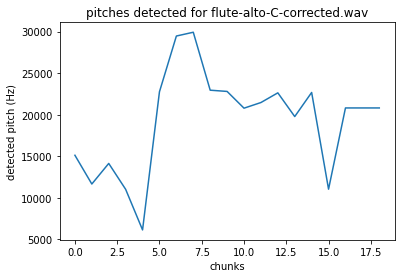

In [4]:
# %%
# test on flute sound
filename = 'flute-alto-C-corrected.wav'
fs, data = read(f'audio/{filename}')
start_time = time.time()
detected_freqs = sequential_processing(data[4410:88200], 300, 4410)
end_time = time.time()
print(f'------------------------------------------- TEST ON AUDIO FILES ----------------------------')
print(f'detected frequency: {detected_freqs}')
plt.figure(1)
plt.xlabel('chunks')
plt.ylabel('detected pitch (Hz)')
plt.title(f'pitches detected for {filename}')
plt.plot(detected_freqs)
print(f'execution time: {end_time - start_time}')




------------------------------------------- TEST ON SINE WAVES ----------------------------
detected frequency: [404.58715596 404.58715596 404.58715596 404.58715596 404.58715596
 404.58715596 404.58715596 404.58715596 404.58715596 404.58715596
 404.58715596 404.58715596]
execution time: 0.09899568557739258


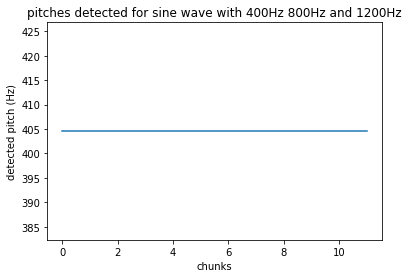

In [3]:
# %%


# test on sine waves
f1 = 400
f2 = 800
f3 = 1200
x = np.arange(100000)
data = np.sin(2 * np.pi * f1 * x / fs) + np.sin(2 * np.pi *
                                                f2 * x / fs) + np.sin(2 * np.pi * f3 * x / fs)
start_time = time.time()
detected_freq = sequential_processing(data, 300, 8820)
end_time = time.time()
print(f'------------------------------------------- TEST ON SINE WAVES ----------------------------')
print(f'detected frequency: {detected_freq}')
print(f'execution time: {end_time - start_time}')

plt.figure(2)
plt.xlabel('chunks')
plt.ylabel('detected pitch (Hz)')
plt.title(f'pitches detected for sine wave with 400Hz 800Hz and 1200Hz')
plt.plot(detected_freq)